<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Load-relevant-data" data-toc-modified-id="Load-relevant-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load relevant data</a></span></li><li><span><a href="#Standard-Scale-the-Climatic-data" data-toc-modified-id="Standard-Scale-the-Climatic-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Standard Scale the Climatic data</a></span></li><li><span><a href="#Regression-task" data-toc-modified-id="Regression-task-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Regression task</a></span></li></ul></div>

In [4]:
import ee
import datetime
import pandas as pd
from IPython.display import Image
from pylab import *
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import shapely
from shapely.ops import cascaded_union
import json
from shapely.geometry import Polygon, MultiPolygon, Point
import geojson
import pickle
import warnings
warnings.filterwarnings('ignore')
import iisignature
import sys
sys.path.append("../")
from utils.addtime import AddTime, LeadLag
from importlib import reload
import utils.experiments as experiments 
import GP_models.GP_sig_precomputed as GP_sig
from IPython.display import Image
import utils.signature_features as signature_features
import esig.tosig as esig
import os
from sklearn.preprocessing import StandardScaler
import unicodedata
import pandas as pd

# Goal

Predict the yearly residential energy consumption (2011-2017) at the level of regions (bigger than NUTS 2) based on climatic variables.

# Load relevant data

In [9]:
base_dir = '/Users/maudlemercier/Desktop/Distribution_Regression_Streams/data_France/'

We have collected the climatic data at the level of pixels in NUTS 2 regions, but the electricity consumption is available at a coarser level. Hence we need to map NUTS 2 regions to the energy consumption regions.

In [10]:
dico_region_nuts = {'Île-de-France':['FR10'],'Centre-Val de Loire':['FRB0'],'Normandie':['FRD1','FRD2'],'Hauts-de-France':['FRE1','FRE2'],'Occitanie':['FRJ1','FRJ2'],'Grand Est':['FRF1','FRF2','FRF3'],'Auvergne-Rhône-Alpes':['FRK1','FRK2'],"Provence-Alpes-Côte d'Azur":['FRL0'],'Nouvelle-Aquitaine':['FRI1','FRI2','FRI3'],'Bretagne':['FRH0'],'Bourgogne-Franche-Comté':['FRC1','FRC2'],'Pays de la Loire':['FRG0']}
nuts_present = ['FR10','FRB0','FRD1','FRD2','FRE1','FRE2','FRJ1','FRJ2','FRF1','FRF2','FRF3','FRK1','FRK2','FRL0','FRI1','FRI2','FRI3','FRH0','FRC1','FRC2','FRG0']

In [11]:
df = pd.read_csv(base_dir+'conso-elec-gaz-annuelle-par-secteur-dactivite-agregee-region.csv', delimiter=';')
df.columns = [unicodedata.normalize('NFKD',x).encode('ASCII', 'ignore') for x in df.columns]

In [13]:
dg = df[[b'Annee',b'Libelle Region',b'Operateur',b'Consommation Residentiel  (MWh)',b'Nombre de points Residentiel']]

dg

,b'Annee',b'Libelle Region',b'Operateur',b'Consommation Residentiel (MWh)',b'Nombre de points Residentiel'
0,2011,Île-de-France,Enedis,29634002.60,6127961
1,2011,Centre-Val de Loire,Enedis,7960092.91,1361015
2,2011,Normandie,Enedis,10877450.58,1866236
3,2011,Hauts-de-France,Enedis,15150658.83,2806578
4,2011,Occitanie,Enedis,18754850.62,3552205
...,...,...,...,...,...
1173,2017,Grand Est,GRT Gaz,0.00,0
1174,2017,Nouvelle-Aquitaine,GRT Gaz,0.00,0
1175,2017,Occitanie,TIGF,0.00,0
1176,2017,Grand Est,Véolia Eau – GRD Gaz,123737.70,7764


Corse is not present in 2011. Hence we decide to drop Corse `'Corse':['FRM0']`

In [14]:
# aggregate the data (over operators)
dg = df[[b'Annee',b'Libelle Region',b'Operateur',b'Consommation Residentiel  (MWh)',b'Nombre de points Residentiel']]
dg = dg.groupby([b'Annee',b'Libelle Region']).sum()

## check regions present each year 
# years = dg.index.get_level_values(b'Annee').unique().values
# for year in years:
#     present = dg[dg.index.get_level_values(b'Annee')==year]
#     regions_present = set(present.index.get_level_values(b'Libelle Region').values) 
#     print(year,len(list(regions_present & set(dico_region_nuts.keys()))))

## Normalize the energy consumption by the number of points
dg['Normalized Conso']=dg[b'Consommation Residentiel  (MWh)']/dg[b'Nombre de points Residentiel']

Load the polygons for NUTS 2 regions

In [15]:
polygons = gpd.read_file('/Users/maudlemercier/Desktop/Learning_Streams_Sets/ref-nuts-2016-20m.shp/NUTS_RG_20M_2016_4326_LEVL_2.shp/NUTS_RG_20M_2016_4326_LEVL_2.shp')
polygons = polygons[polygons.CNTR_CODE=='FR']

# merge NUTS 2 polygons which are in a common region
poly_regions = pd.DataFrame(dico_region_nuts.keys(),columns=['region'])
poly_regions['geometry'] = np.nan


for region in dico_region_nuts.keys():
    nuts_within_region = polygons[polygons.FID.isin(dico_region_nuts[region])].geometry.values
    for i,nut in enumerate(nuts_within_region):
        if nut.type == 'MultiPolygon':
            nuts_within_region[i] = nut[0]
    poly_regions.loc[poly_regions.region==region,"geometry"] = cascaded_union(nuts_within_region)

Merge the energy consumption data with the polygons

In [16]:
list_year = []

years = [str(e) for e in np.arange(2011,2018)]

for year in years:
    
    g_df = gpd.GeoDataFrame(pd.DataFrame(poly_regions[['geometry','region']], columns = ['geometry','region']), geometry = 'geometry')
    g_df["Normalized Conso"] = np.nan
    g_df["year"] = year
    g_df["colors"] = sns.hls_palette(len(list(dico_region_nuts.keys())))
    
    for region in poly_regions.region.values:
        df_region = dg[dg.index.isin([(int(year),region)])]
        g_df.loc[g_df.region==region,"Normalized Conso"] = df_region['Normalized Conso'].values[0]
    list_year.append(g_df)


data = pd.concat(list_year)
data.crs = {'init': 'epsg:4326'}
data=data.to_crs("EPSG:3395")

Visualize the variability over years

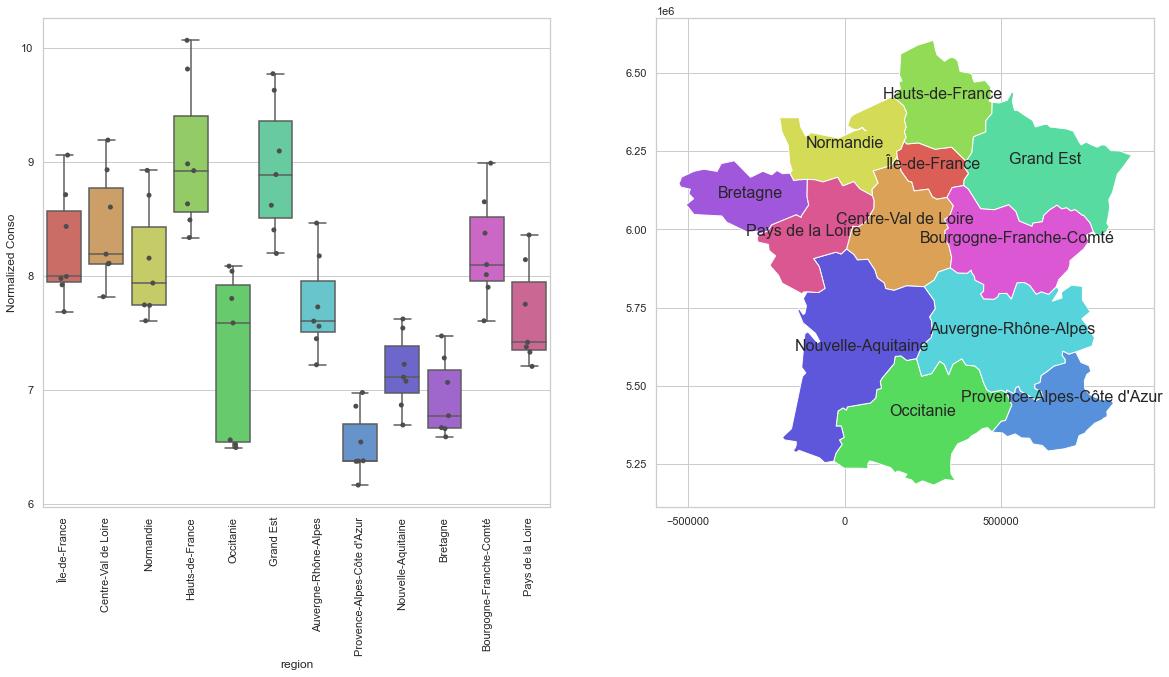

In [17]:
sns.set(style="whitegrid")
fig,ax = plt.subplots(1,2,figsize=(20,9))
axs = ax.ravel()
ax = sns.boxplot(x='region', y="Normalized Conso", data=data, whis=np.inf,palette=sns.hls_palette(len(list(dico_region_nuts.keys()))),ax=ax[0])
ax = sns.stripplot(x='region', y="Normalized Conso", data=data, color=".3",ax=axs[0])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

sns.set(font_scale=3)
g_plot = data[data.year==year].plot(ax=axs[1],color=data[data.year==year].colors)

df = data[data.year==year]
df['coords'] = df['geometry'].apply(lambda x: x.representative_point().coords[:])
df['coords'] = [coords[0] for coords in df['coords']]
for idx, row in df.iterrows():
    plt.annotate(s=row['region'], xy=row['coords'],
                 horizontalalignment='center',fontsize=16)

plt.show()

# Standard Scale the Climatic data

Reorganize the data into folders

In [ ]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

clim_var = ['AvgSurfT_inst_', 'SoilMoi0_10cm_inst_', 'Rainf_f_tavg_']
            
# create one directory per nut
for nut in nuts_present:
    mkdir_p(os.path.join(base_dir+'standardized_data_yearly', nut))

# Create a list of time series on which we will fit the standard scaler
training_list = []
for year in np.arange(2011,2018):
    print('year: ', year)
    for nut in nuts_present:
        clim = pickle.load(open(base_dir+nut+'_2005_2018.obj','rb'))
        
        # subset the dataframe on the correct year
        clim = clim.loc[str(year)+'-01-01':str(year+1)+'-01-01']
        
        # number of pixels in nut
        nb_pixels = int(len(clim.columns)/3)
        for pix in range(nb_pixels):
            col_pix = [clim_var[i]+str(pix) for i in range(3)]
            training_list.append(clim[col_pix].to_numpy())
            
## Fit the standard scaler on the training data
scaler = StandardScaler()

to_fit = np.concatenate(training_list, axis=0)

# fit the scaler
scaler.fit(to_fit)

We have fitted the standard scaler. Now we transform the dataset, and save the results

In [ ]:
# for year in np.arange(2011,2018):
#     print(year)
#     for nut in nuts_present:
        
#         # will be a list of numpy arrays corresponding to the pixels within the nut for that year
#         pixels = []
        
#         # subset the dataframe on the correct year
#         clim = pickle.load(open(base_dir+nut+'_2005_2018.obj','rb'))
#         clim = clim.loc[str(year)+'-01-01':str(year+1)+'-01-01']

#         # number of pixels in nut
#         nb_pixels = int(len(clim.columns)/3)
#         for pix in range(nb_pixels):
#             col_pix = [clim_var[i]+str(pix) for i in range(3)]
#             pixels.append(scaler.transform(clim[col_pix].to_numpy()))
#         pickle.dump(pixels,open(base_dir+'standardized_data_yearly/'+nut+'/'+str(year)+'.obj','wb'))

# Regression task

In [80]:
# signature spec
level_sig = 4
add_time_tf = AddTime()
lead_lag_tf = LeadLag([1])
sig_level1 = 4
sig_level2 = 2

# to store the input/output pairs
expected_sigs = [] 
labels = {}
input_list = []

clim_var = ['AvgSurfT_inst_', 'SoilMoi0_10cm_inst_', 'Rainf_f_tavg_']
      
def process_one_nut(df,year):
    list_pixels_nut = []
    # subset the dataframe on the correct year
    df = df.loc[str(year)+'-01-01':str(year+1)+'-01-01']
#     df.plot(legend=False,rot=45)
#     plt.show()
    nb_pixels = int(len(df.columns)/3)
    col_temp = ['AvgSurfT_inst_'+str(pix) for pix in range(nb_pixels)]
    col_rain = ['Rainf_f_tavg_'+str(pix) for pix in range(nb_pixels)]
    df[col_temp]=df[col_temp]-273
    df[col_rain] = 50000*df[col_rain]
    for pix in range(nb_pixels):
        col_temp = ['AvgSurfT_inst_'+str(pix)]
        col_rain = ['Rainf_f_tavg_'+str(pix)]
        col_pix = col_temp + col_rain
        #df[col_pix].plot(legend=True,rot=45)
        df['cumsum_temp'] = 0.01*df[col_temp].cumsum()
        list_pixels_nut.append(df[['cumsum_temp']].to_numpy())
    
    return list_pixels_nut


for year in np.arange(2011,2018):
    
    print('year: ', year)
    for region in dico_region_nuts.keys():

        # collect all the data in the region. May involve multiple nuts
        nuts = dico_region_nuts[region]
        pixels = []
        for nut in nuts:
            one_nut = pickle.load(open(base_dir+nut+'_2005_2018.obj','rb'))
            one_nut = process_one_nut(one_nut,year)
            pixels = pixels + one_nut
        input_list.append(pixels)
        pixels = add_time_tf.fit_transform(pixels) 
        #pixels = lead_lag_tf.fit_transform(pixels)
        expected_sig = np.mean(iisignature.sig(pixels,level_sig),axis=0)
        expected_sigs.append(expected_sig)

        label = data[data.year==str(year)]
        label = label[label.region==region]

        label = label[['Normalized Conso']].values[0]
        labels[(year,region)]=label
 

# # save the paths for comparison with baseline    
pickle.dump(input_list,open('input_list_RBF.obj','wb')) 
pickle.dump(np.array([labels[key] for key in labels.keys()]),open('output_RBF.obj','wb')) 

year:  2011
year:  2012
year:  2013
year:  2014
year:  2015
year:  2016
year:  2017


 Precompute the Gram Matrix with elements $\langle \mathbb{E}[S(x^i)],\mathbb{E}[S(x^j)]\rangle$

In [82]:
input_list[0][0].shape

(2920, 1)

In [78]:
train_indices = np.arange(72-12)
test_indices = np.arange(72-12,84)

labels = np.array([labels[key] for key in labels.keys()])

features = np.array(expected_sigs) 
print(features.shape)

# Scale the (expected) signature features
scaler = StandardScaler()
to_fit = [features[i] for i in train_indices]
scaler.fit(to_fit)
features = scaler.transform(features)

# scaler = StandardScaler()
# to_fit = [labels[i] for i in train_indices]
# scaler.fit(to_fit)
# labels = scaler.transform(labels)

# feat_select = [3,9,10,30]
# features = features[:,feat_select]
# print(features.shape)

# # Precompute the Gram matrix
K_precomputed = experiments.precompute_K(features)

(84, 30)


Fit the model

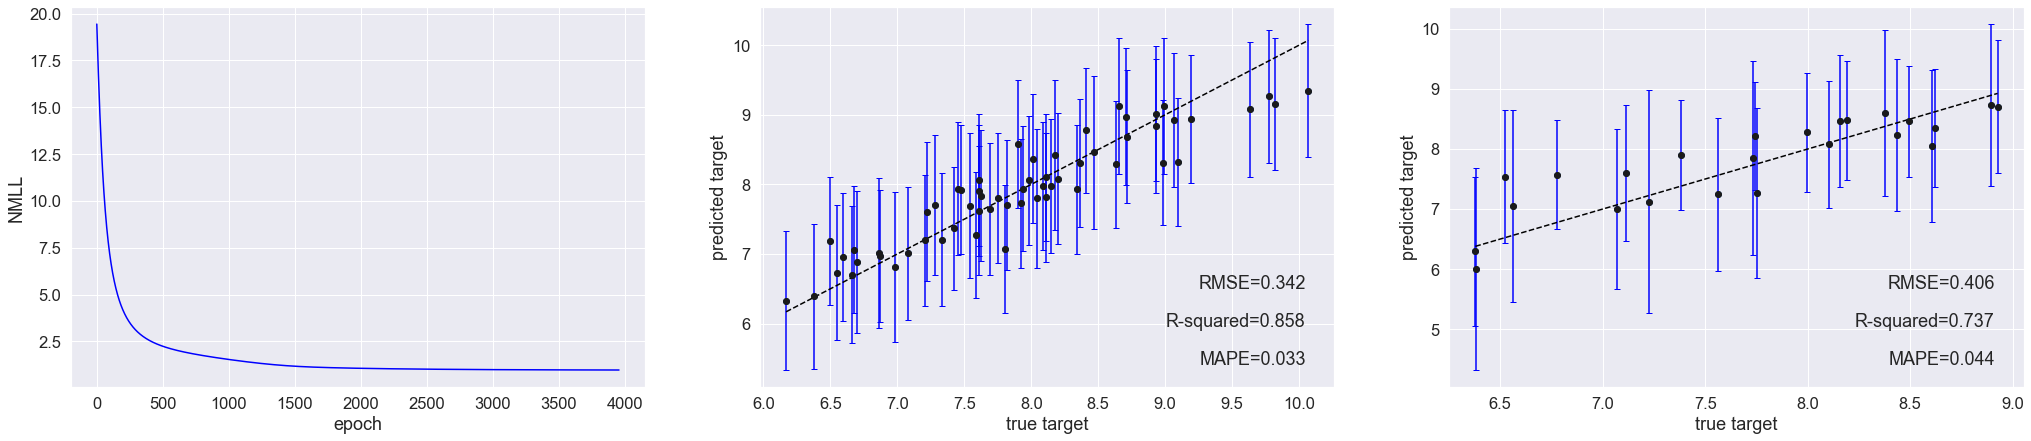

In [79]:
reload(experiments)
reload(GP_sig)
import GP_models.GP_sig_ARD_full as GP_sig_ARD_full
reload(GP_sig_ARD_full)
a,b,c,d = experiments.experiment_precomputed(K_precomputed, labels,train_indices,test_indices,param_init=[0,0,0],RBF=True,plot=True)
#a,b,c,d,l = experiments.experiment_ARD(features,labels,5,level_sig,train_indices,test_indices,param_init=[0,0,0],RBF=True,plot=True,full=True)

39
39


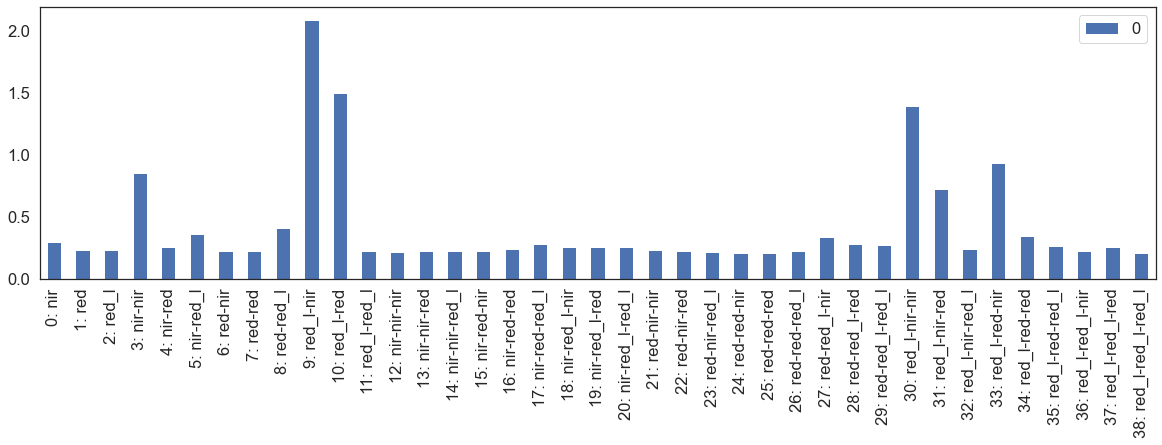

In [343]:
def get_sig_keys(ndims, sig_level):
    keys = esig.sigkeys(ndims,sig_level).split("(")
    sig_keys = []

    for i in range(2,len(keys)-1):
        sig_keys.append(np.array(keys[i][:-2].split(',')))
    sig_keys.append(np.array(keys[len(keys)-1][:-1].split(',')))
    return sig_keys
keys = get_sig_keys(3, level_sig)
#dico = {'1':'time', '2':'nir','3':'red','4':'nir_l','5':'red_l'}#,'3':'red','4':'nir-lag'}
dico = {'1':'nir','2':'red','3':'red_l'}#,'4':'red_l'}
features_names = []
for i in range(features.shape[1]):
    separator = '-'
    name = separator.join([dico[e] for e in keys[i]])
    features_names.append(str(i)+': '+name)
print(len(features_names))
print(features.shape[1])
fig, ax = plt.subplots(1,figsize=(20,5))
lengthscales = pd.DataFrame([1./e for e in l][:50])
lengthscales.index = features_names[:50]
lengthscales.plot(kind='bar',ax=ax,rot=90)
plt.show()

